In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms
import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    

# input params

In [2]:
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie

In [3]:
print('str_aggregated_path: ', str_aggregated_path)
print('str_genome_scores: ', str_genome_scores)
print('str_tag_ids: ', str_tag_ids)
print('str_rating_path: ', str_rating_path)
print('str_data_folder: ', str_data_folder)
print('str_aggregated_path: ', str_aggregated_path)
print('minimum_no_of_frames: ', minimum_no_of_frames)
print('number_of_tag_per_movie: ', number_of_tag_per_movie)

str_aggregated_path:  ..\..\data\MA14KD_AGGREGATED.csv
str_genome_scores:  ..\..\data\ml-20m\genome-scores.csv
str_tag_ids:  ..\..\data\ml-20m\genome-tags.csv
str_rating_path:  ..\..\data\ml-20m\ratings.csv
str_data_folder:  ..\..\data
str_aggregated_path:  ..\..\data\MA14KD_AGGREGATED.csv
minimum_no_of_frames:  10
number_of_tag_per_movie:  10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path)

In [8]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col='movieId').sort_index()
df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [9]:
print(df_agg.shape, df_genome.shape)
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print(df_agg.shape, df_genome.shape)

(13923, 39) (11709768, 3)
(5650, 39) (6373200, 3)


In [10]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [11]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]

# Compute tag genome based on visual features

In [12]:
normalizer = pp.QuantileTransformer(output_distribution='normal')


In [13]:
%%time
df_predicted_tag_genome = ms_tg_builder.cross_val_predict(df_visual_features=df_agg,
                                                          df_genome_scores=df_genome,
                                                          normalizer_vf=normalizer,
                                                          n_splits=10, 
                                                          n_jobs=10)

Wall time: 20.4 s


In [14]:
item_features_vf = rpp.get_item_feature_from_tag_genome(df_predicted_tag_genome, number_of_tag_per_movie)

# Train test split

In [15]:
reload()
df_rating_train, df_rating_test, item_features_train, item_features_test = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

In [16]:
reload()
df_rating_vf_train, df_rating_vf_test, item_features_vf_train, item_features_vf_test = \
    rms.train_test_split(df_ratings_filtered, item_features_vf, strategy='sklearn', test_size=.25)

# Train the content based recommender and predict on test on original tag genome

In [17]:
recommend = item_based.ItemBasedColabCos()
recommend.fit(df_rating_train, item_features_train)

In [18]:
%%time
test_users = df_rating_test[config.userId_col].unique()
recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=10)

Wall time: 6min 20s


In [ ]:
recommendations.rename(columns={f'{config.rating_col}_predicted': f'{config.rating_col}_predicted_tg'},
                       inplace=True)

In [ ]:
df_rating_pred = pd.merge(df_rating_test, recommendations, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual_tg'] = df_rating_pred[config.rating_col] - df_rating_pred[f'{config.rating_col}_predicted_tg']

In [ ]:
df_rating_pred['absolute residual_tg'] = df_rating_pred['residual_tg'].abs()

In [ ]:
no_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted_tg'].isnull().sum()
share_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted_tg'].isnull().mean()

if no_of_null_predictions > 0:
    print(f'Warning: {no_of_null_predictions} ({np.round(share_of_null_predictions * 100 , 2)}%)'
          ' of ratings has no prediciton')

# Train the content based recommender and predict on test on VF tag genome

In [ ]:
recommend_vf_tg = item_based.ItemBasedColabCos()
recommend_vf_tg.fit(df_rating_vf_train, item_features_vf_train)

In [ ]:
%%time
test_users_vf = df_rating_vf_test[config.userId_col].unique()
recommendations_vf_tg = recommend_vf_tg.\
    predict_on_list_of_users(test_users_vf, df_rating_vf_test, item_features_vf_test, n_jobs=10)
recommendations_vf_tg.rename(columns={f'{config.rating_col}_predicted': f'{config.rating_col}_predicted_vf_tg'},
                            inplace=True)

Wall time: 6min 21s


In [ ]:
df_rating_pred = pd.merge(df_rating_pred, recommendations_vf_tg, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual_vf_tg'] = df_rating_pred[config.rating_col] -\
                                   df_rating_pred[f'{config.rating_col}_predicted_vf_tg']

In [ ]:
df_rating_pred['absolute residual_vf_tg'] = df_rating_pred['residual_vf_tg'].abs()

In [ ]:
no_of_null_predictions_vf_tg = df_rating_pred[f'{config.rating_col}_predicted_vf_tg'].isnull().sum()
share_of_null_predictions_vf_tg = df_rating_pred[f'{config.rating_col}_predicted_vf_tg'].isnull().mean()

if no_of_null_predictions > 0:
    print(f'Warning: {no_of_null_predictions_vf_tg} ({np.round(share_of_null_predictions_vf_tg * 100 , 2)}%)'
          ' of ratings has no prediciton')

# Train the baseline recommender and predict on test

In [ ]:
recommend_dummy = dummy_recommender.DummyAverageUser()
recommend_dummy.fit(df_rating_train, item_features_train)

In [ ]:
%%time
recommendations_dummy = recommend_dummy.predict_on_list_of_users(test_users, 
                                                                 df_rating_test, 
                                                                 item_features_test, 
                                                                 n_jobs=10)
recommendations_dummy.rename(columns={f'{config.rating_col}_predicted': f'{config.rating_col}_predicted_average_user'},
                            inplace=True)

Wall time: 4min 53s


In [ ]:
df_rating_pred = pd.merge(df_rating_pred, recommendations_dummy, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual_average_user'] =\
    df_rating_pred[config.rating_col] - df_rating_pred[f'{config.rating_col}_predicted_average_user']

In [ ]:
df_rating_pred['absolute residual_average_user'] = df_rating_pred['residual_average_user'].abs()

# looking at the performance

In [ ]:
prediction_column_suffixes = []
for c in df_rating_pred.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['tg', 'vf_tg', 'average_user']

In [ ]:
reload()
pd.concat([tools.performance_report(df_rating_pred, prediction_column_suffix=alg) for alg in prediction_column_suffixes])

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
tg,3.517691,0.694317,0.904489,0.257126,0.266465,0.904595,-0.014608
vf_tg,3.517691,0.764954,0.982921,0.279422,0.133733,0.984170,0.000996
average_user,3.517691,0.759244,0.971919,0.276295,0.153017,0.972972,-0.001816


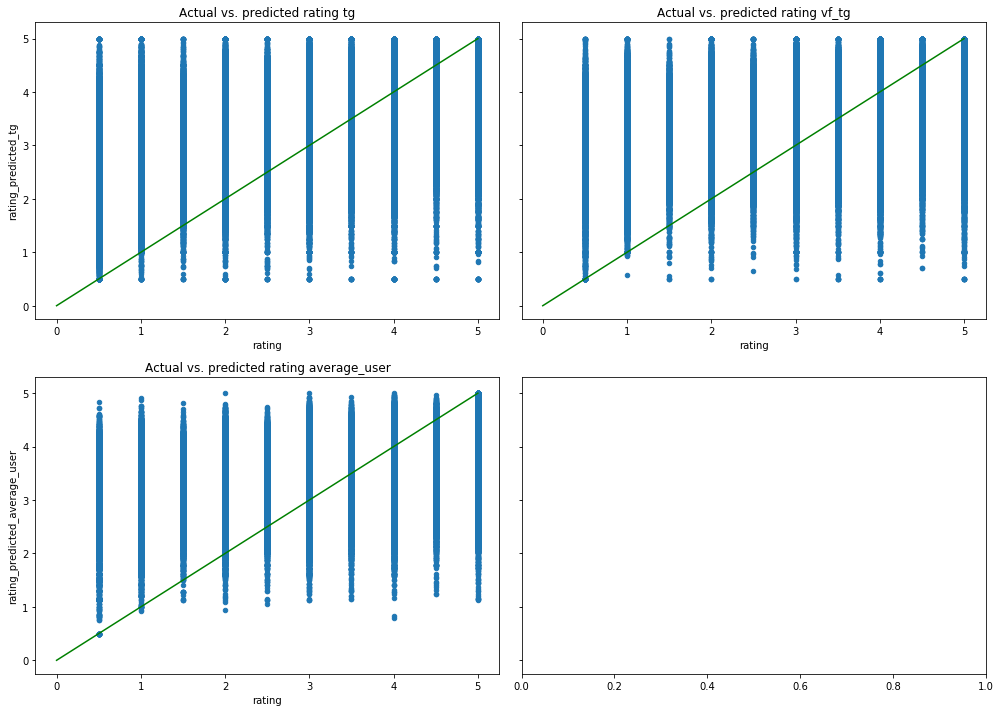

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_pred,
                            prediction_column_suffixes=prediction_column_suffixes)

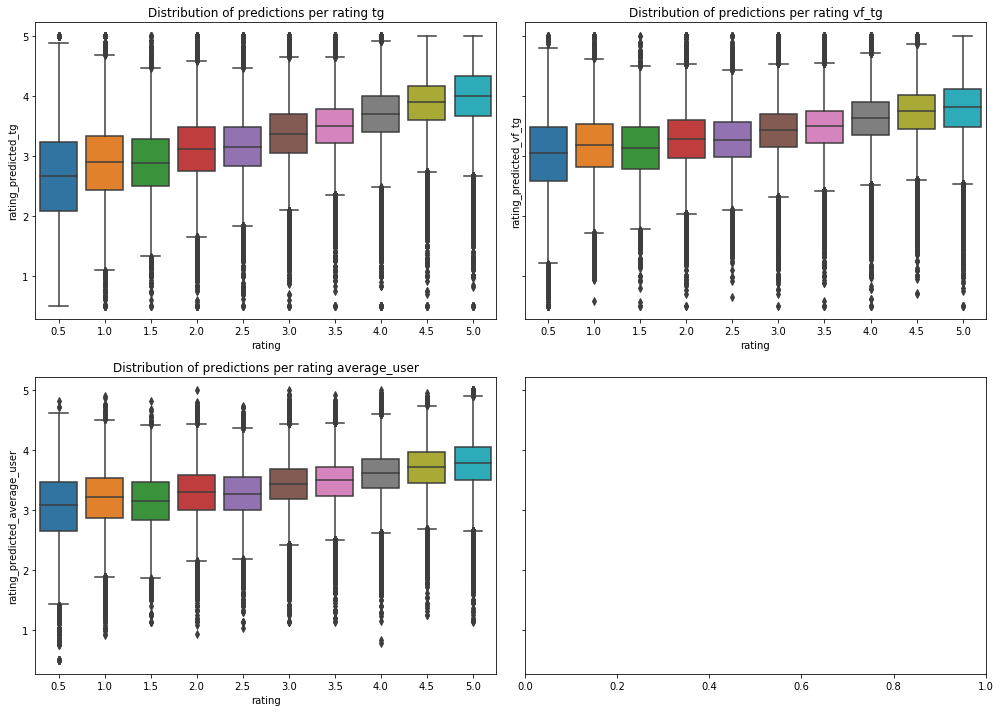

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_pred,
                            prediction_column_suffixes=prediction_column_suffixes)

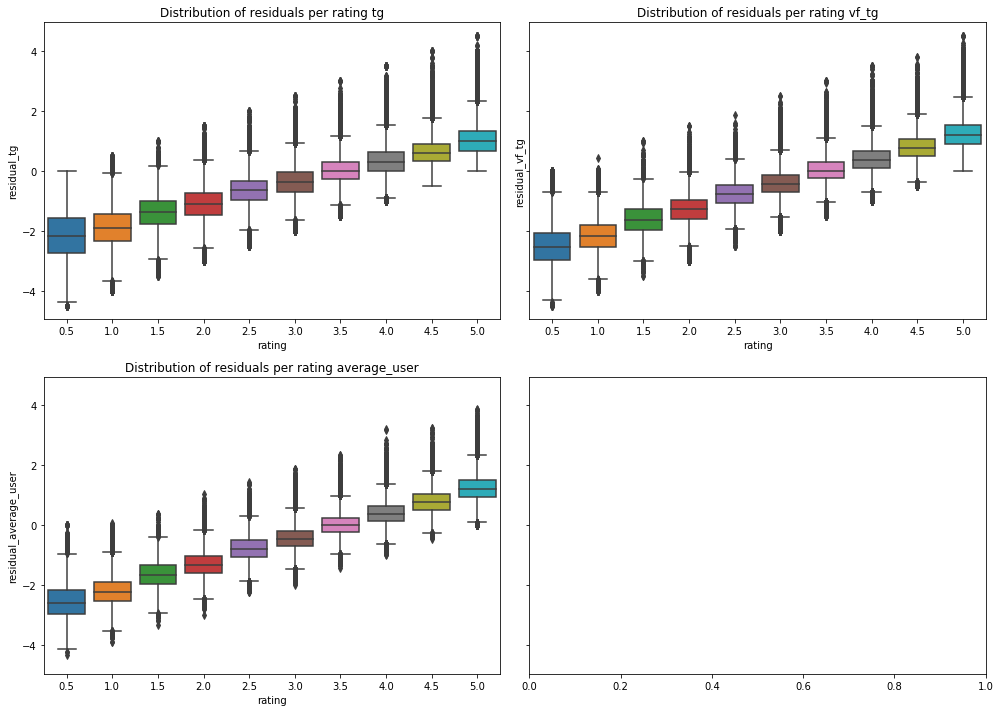

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_pred,
                            prediction_column_suffixes=prediction_column_suffixes)

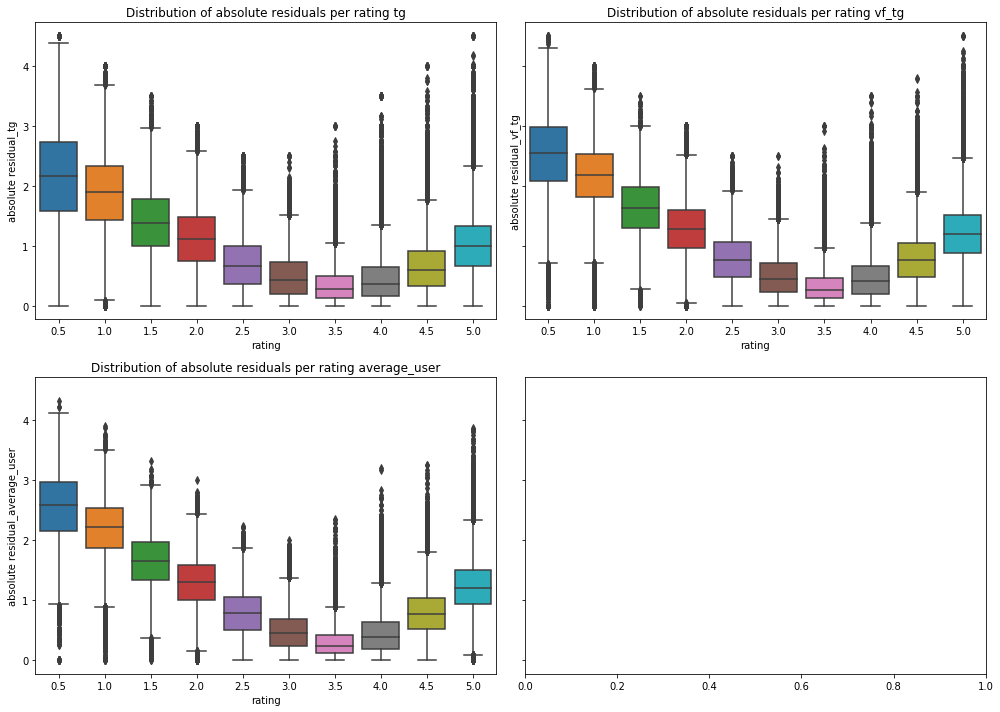

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_pred,
                            prediction_column_suffixes=prediction_column_suffixes)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


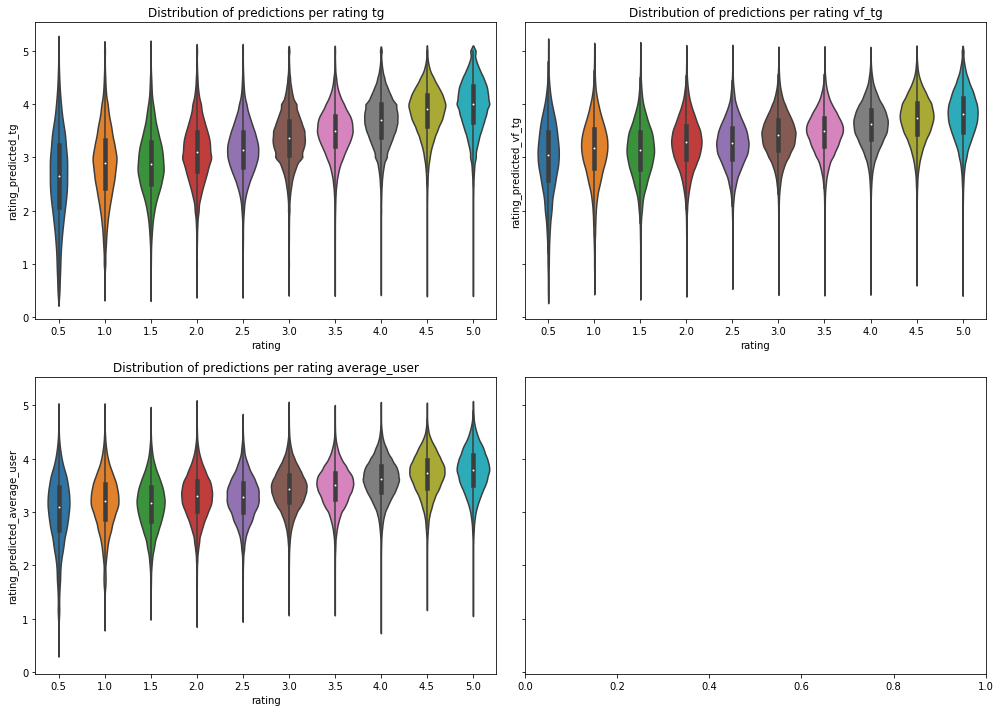

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
                            df_rating_pred=df_rating_pred,
                            prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook in the results folder

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')